# Multilayer Perceptron

In this notebook, we briefly introduce the multilayer perceptron model, then apply it on the palmer penguins dataset.

---

## Introduce 

A [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) is a class of feedforward artificial neural network (ANN). An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.

---

## Algorithm

A multilayer neural network is multilayer of perceptrons. It consists an input layer, several hidden layers, output layer, fully connected weights and non-linear activation function. The architecture of MLP is shown in the following image.

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C(W, b) = \frac{1}{2}\sum_{k=1}^{2}(\hat{y}^{(i)}_k - y^{(i)}_k)^2.
$$

### Feedforward Phase

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. 

### Backpropogation Phase with Stochastic Gradient Descent 
The backpropogation phase with stochastic gradient descetn is shown as below:

1. For each $i = 1, \dots, N$.
2. Feedforward $\mathbf{x}^{(i)}$ into the network. 
3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.
4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.
5. For $\ell = L, L-1, \dots, 1$, 

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$

---

## Implementation

In [1]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set theme for plotting
sns.set_theme()

First, we define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data.

In [2]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(len(y)))[0]

Next we write a custom function to initialize the weight matrices and bias column vectors for a dense neural network.

In [3]:
def initialize_weights(layers):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

Then we define the feedforward phase funciton and the overall MSE cost funciton.

In [4]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        xi = xi.reshape(-1,1)
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

We are now ready to define a custom Python ```DenseNetwork``` class.

In [5]:
class DenseNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 20):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                xi = xi.reshape(-1,1)
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

## Application

In this part, we will use the multilayer perceptron algorithms we build to judge the sex of penguins based on the rest features of the dataset.

In [6]:
# Import the data
df = pd.read_csv("./Datasets/palmer_penguins.csv", encoding='utf-8-sig')

# Data Preprocessing by onehot encoding
# df.species = df.species.replace({'Adelie':0, 'Chinstrap':1, 'Gentoo':2})
df.sex = df.sex.replace({'Male': 0, 'Female':1})
island = pd.get_dummies(df.island)
species = pd.get_dummies(df.species)
df = pd.concat([df, island, species], axis = 1)
df.drop(['Unnamed: 0','island', 'species'],axis=1,inplace=True)

# Standardize the data
df.bill_length_mm = preprocessing.scale(df.bill_length_mm)
df.bill_depth_mm = preprocessing.scale(df.bill_depth_mm)
df.flipper_length_mm = preprocessing.scale(df.flipper_length_mm)
df.body_mass_g = preprocessing.scale(df.body_mass_g)

In [7]:
df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Biscoe,Dream,Torgersen,Adelie,Chinstrap,Gentoo
0,-0.896042,0.780732,-1.426752,-0.568475,0,0,0,1,1,0,0
1,-0.822788,0.119584,-1.069474,-0.506286,1,0,0,1,1,0,0
2,-0.676280,0.424729,-0.426373,-1.190361,1,0,0,1,1,0,0
3,-1.335566,1.085877,-0.569284,-0.941606,1,0,0,1,1,0,0
4,-0.859415,1.747026,-0.783651,-0.692852,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
328,0.587352,-1.762145,0.931283,0.892957,1,1,0,0,0,0,1
329,0.514098,-1.457000,1.002739,0.799674,1,1,0,0,0,0,1
330,1.173384,-0.744994,1.502928,1.919069,0,1,0,0,0,0,1
331,0.221082,-1.202712,0.788372,1.234995,1,1,0,0,0,0,1


We import the data set and preprocess it.

We create the training set and testing set.

In [8]:
X = df.drop('sex',axis=1).to_numpy()
y = df.sex

# Create a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Then we onehot encode the response variable.

In [9]:
# One hot encode the training labels
onehot_y_train = []

for y in zip(y_train):
    temp_vec = np.zeros((2, 1))
    temp_vec[y][0] = 1.0
    onehot_y_train.append(temp_vec)

We initialize a ```DenseNetwork``` Class with layers = [10,6,4,2]. Then we examine our MLP class by making a random prediction before training.

In [10]:
# Initialize a network with 15 input nodes, two hidden layers with 4 nodes each 
# and a output layer with 2 nodes. 
np.random.seed(1)
net = DenseNetwork(layers = [10 ,6, 4, 2])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, X_train, onehot_y_train) = {MSE(net.W, net.B, X_train, onehot_y_train)} \n")

# Make a random prediction before training
np.random.seed(2)
i = np.random.randint(0, len(X_test))
prediction = net.predict(X_test[i].reshape(-1,1))
print(f"predicted label is: {prediction}")
print(f"actual label is: {np.argmax(y_test.iloc[i])}")

MSE(net.W, net.B, X_train, onehot_y_train) = 0.2646066612179219 

predicted label is: 1
actual label is: 0


We train the MLP on the training set with epochs = 10.

In [11]:
# Train your network with stochastic gradient descent!
net.train(X_train, onehot_y_train, alpha = 0.046, epochs= 10)

Starting Cost = 0.2646066612179219
1-Epoch Cost = 0.24733364833671165
2-Epoch Cost = 0.24536517386618956
3-Epoch Cost = 0.24372112035762888
4-Epoch Cost = 0.24164941499990078
5-Epoch Cost = 0.2389584401025999
6-Epoch Cost = 0.23542558475900152
7-Epoch Cost = 0.2307682453120301
8-Epoch Cost = 0.22465567596172464
9-Epoch Cost = 0.2167697403973254
10-Epoch Cost = 0.20693352745990126


Now let's check the prediction result after training.

In [12]:
prediction = net.predict(X_test[i].reshape(-1,1))
print(f"predicted label is: {prediction}")
print(f"actual label is: {np.argmax(y_test.iloc[i])}")

predicted label is: 1
actual label is: 0


We will visualize the MSE over each epoch.

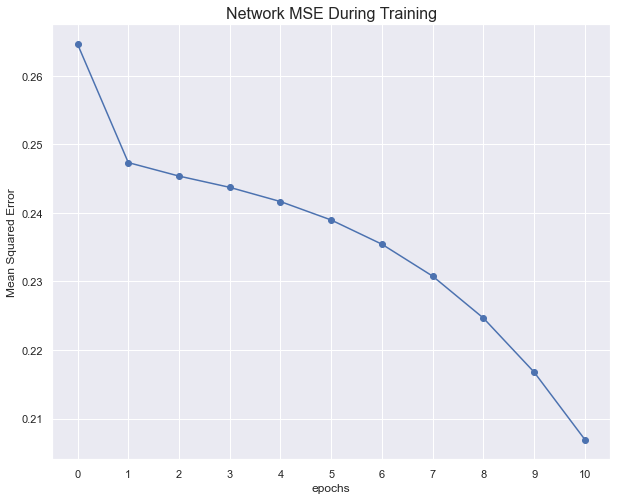

In [13]:
# Visualize the mean squared error over the training process 
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

The MSE decreases over each epoch. Now we will make prediction on the testing set and show the confusion matrix and classificaiton report.

cf_matrix = [[39 13]
 [ 5 43]] 



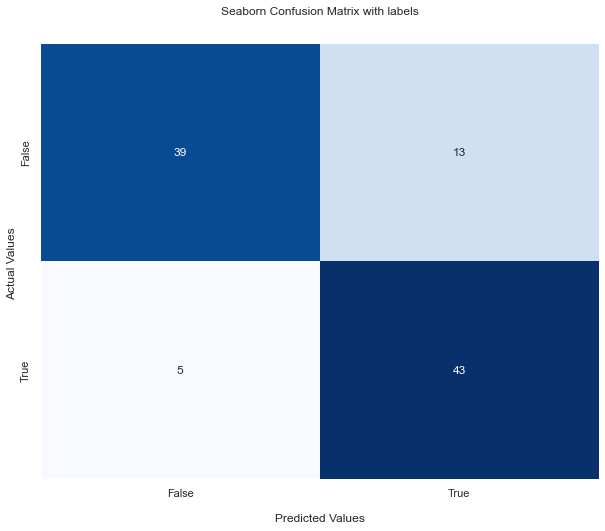

In [14]:
# Make predictions on testing data
y_pred = []
for xi in X_test:
    y_pred.append(net.predict(xi.reshape(-1,1)))

# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix 
print(f"cf_matrix = {cf_matrix} \n")

# View the confusion matrix using the seaborn package
plt.figure(figsize = (10, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [15]:
#Check performance of our model with classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81        52
           1       0.77      0.90      0.83        48

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



The MLP model's accuracy is 83%


## Using TensorFlow package for the same task

TensorFlow is an open-source library developed by Google primarily for deep learning applications. It also supports traditional machine learning. TensorFlow was originally developed for large numerical computations without keeping deep learning in mind. However, it proved to be very useful for deep learning development as well, and therefore Google open-sourced it.

TensorFlow accepts data in the form of multi-dimensional arrays of higher dimensions called tensors. Multi-dimensional arrays are very handy in handling large amounts of data.

TensorFlow works on the basis of data flow graphs that have nodes and edges. As the execution mechanism is in the form of graphs, it is much easier to execute TensorFlow code in a distributed manner across a cluster of computers while using GPUs.

Then, we will do the same process of above with tensorflow package and compare the performance of two different process.

In [18]:
import tensorflow as tf   # import tensorflow package

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(7, activation='sigmoid'),
  tf.keras.layers.Dense(2)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
8/8 [==============================] - 1s 3ms/step - loss: 0.7070 - accuracy: 0.5107
Epoch 2/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6988 - accuracy: 0.5451
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5622
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5536
Epoch 5/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5665
Epoch 6/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6739 - accuracy: 0.5708
Epoch 7/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6684 - accuracy: 0.5665
Epoch 8/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6629 - accuracy: 0.5665
Epoch 9/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6577 - accuracy: 0.5708
Epoch 10/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.5794
Epoch 11/50
8/8 [======================

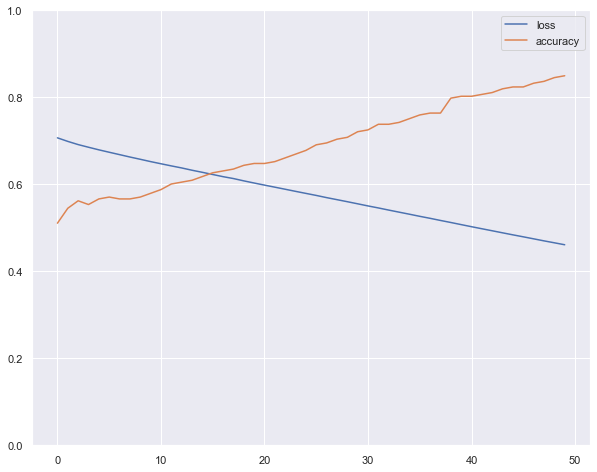

In [20]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [21]:
model.evaluate(X_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.4671 - accuracy: 0.8500 - 168ms/epoch - 42ms/step


[0.4670584797859192, 0.8500000238418579]

The accuracy by using TensorFlow package is also about 85%, higher than the multilayer perceptron model we built.

---

## Conclusion

From the result above, we can see that the multilayer perceptron model performs well on the palmer penguins data. Compared with the single neuron perceptron model, the multilayer perceptron model has higher accuracy. The main reason is that the multilayer perceptron model can deal with non-linearly separable data, solve the problem from a higher pers.